In [ ]:
!pip install tensorflow-gpu==2.0.0-alpha0

ERROR: Could not find a version that satisfies the requirement tensorflow-gpu==2.0.0-alpha0 (from versions: 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.8.1, 2.8.2, 2.8.3, 2.8.4, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2, 2.9.0, 2.9.1, 2.9.2, 2.9.3, 2.10.0rc0, 2.10.0rc1, 2.10.0rc2, 2.10.0rc3, 2.10.0, 2.10.1, 2.11.0rc0, 2.11.0rc1, 2.11.0rc2, 2.11.0, 2.12.0)
ERROR: No matching distribution found for tensorflow-gpu==2.0.0-alpha0


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM

from tensorflow.keras.models import Sequential

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)

In [ ]:
# Data comes from:
# https://finance.yahoo.com/quote/BTC-USD/history?period1=1279314000&period2=1556053200&interval=1d&filter=history&frequency=1d
# csv_path = "https://raw.githubusercontent.com/curiousily/Deep-Learning-For-Hackers/master/data/3.stock-prediction/AAPL.csv"

csv_path = "https://raw.githubusercontent.com/curiousily/Deep-Learning-For-Hackers/master/data/3.stock-prediction/BTC-USD.csv"


In [ ]:
df = pd.read_csv(csv_path, parse_dates=['Date'])

In [ ]:
df = df.sort_values('Date')

In [ ]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-07-16,0.04951,0.04951,0.04951,0.04951,0.04951,0
1,2010-07-17,0.04951,0.08585,0.05941,0.08584,0.08584,5
2,2010-07-18,0.08584,0.09307,0.07723,0.08080,0.08080,49
3,2010-07-19,0.08080,0.08181,0.07426,0.07474,0.07474,20
4,2010-07-20,0.07474,0.07921,0.06634,0.07921,0.07921,42


In [ ]:
df.shape

(3201, 7)

Text(0, 0.5, 'Close Price (USD)')

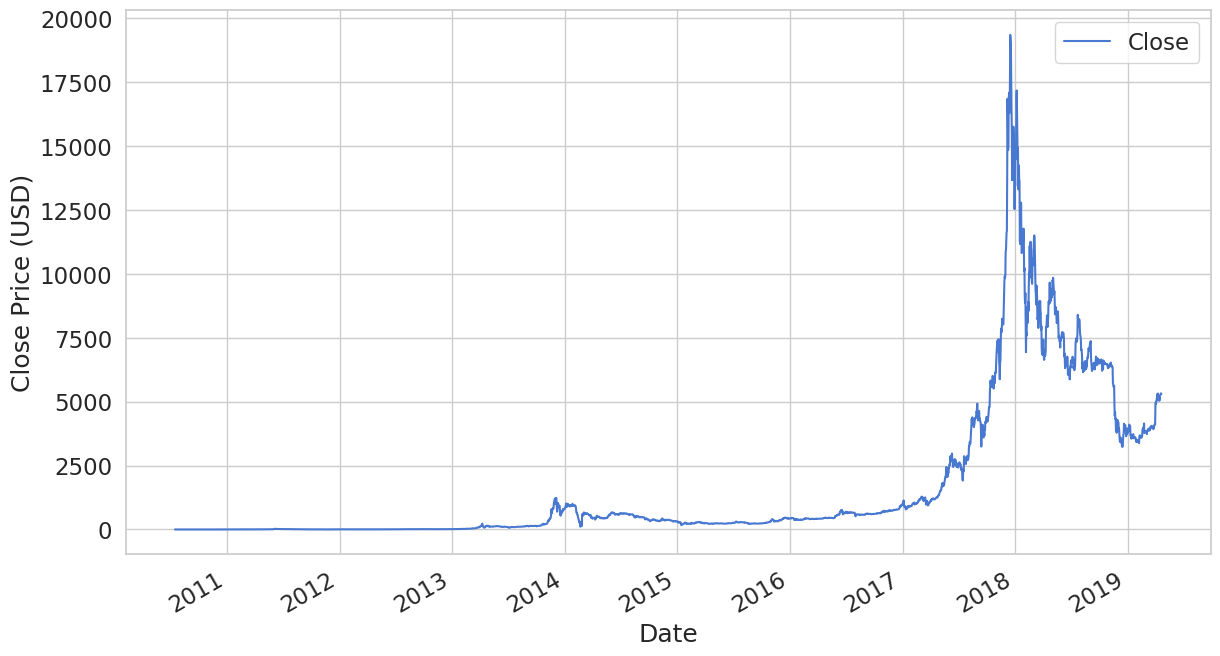

In [ ]:
ax = df.plot(x='Date', y='Close');
ax.set_xlabel("Date")
ax.set_ylabel("Close Price (USD)")

# Normalization

In [ ]:
scaler = MinMaxScaler()

close_price = df.Close.values.reshape(-1, 1)

scaled_close = scaler.fit_transform(close_price)

In [ ]:
scaled_close.shape

(3201, 1)

In [ ]:
np.isnan(scaled_close).any()

False

In [ ]:
scaled_close = scaled_close[~np.isnan(scaled_close)]

In [ ]:
scaled_close = scaled_close.reshape(-1, 1)

In [ ]:
np.isnan(scaled_close).any()

False

# Preprocessing

In [ ]:
SEQ_LEN = 100

def to_sequences(data, seq_len):
    d = []

    for index in range(len(data) - seq_len):
        d.append(data[index: index + seq_len])

    return np.array(d)

def preprocess(data_raw, seq_len, train_split):

    data = to_sequences(data_raw, seq_len)
    num_train = int(train_split * data.shape[0])
    print(num_train)
    print(data)

    X_train = data[:num_train, :-1, :]
    y_train = data[:num_train, -1, :]
    print("a")
    print(X_train)

    X_test = data[num_train:, :-1, :]
    print("B")
    print(X_test)
    y_test = data[num_train:, -1, :]

    return X_train, y_train, X_test, y_test


X_train, y_train, X_test, y_test = preprocess(scaled_close, SEQ_LEN, train_split = 0.95)

2945
[[[0.00000000e+00]
  [1.87796187e-06]
  [1.61743537e-06]
  ...
  [2.73914669e-06]
  [2.89422199e-06]
  [3.38529377e-06]]

 [[1.87796187e-06]
  [1.61743537e-06]
  [1.30418326e-06]
  ...
  [2.89422199e-06]
  [3.38529377e-06]
  [4.26405380e-06]]

 [[1.61743537e-06]
  [1.30418326e-06]
  [1.53524546e-06]
  ...
  [3.38529377e-06]
  [4.26405380e-06]
  [5.21001312e-06]]

 ...

 [[2.09263290e-01]
  [1.89610588e-01]
  [1.89664867e-01]
  ...
  [2.69456800e-01]
  [2.70668957e-01]
  [2.73433961e-01]]

 [[1.89610588e-01]
  [1.89664867e-01]
  [1.89415709e-01]
  ...
  [2.70668957e-01]
  [2.73433961e-01]
  [2.73732729e-01]]

 [[1.89664867e-01]
  [1.89415709e-01]
  [1.83567308e-01]
  ...
  [2.73433961e-01]
  [2.73732729e-01]
  [2.75317101e-01]]]
a
[[[0.00000000e+00]
  [1.87796187e-06]
  [1.61743537e-06]
  ...
  [2.97175964e-06]
  [2.73914669e-06]
  [2.89422199e-06]]

 [[1.87796187e-06]
  [1.61743537e-06]
  [1.30418326e-06]
  ...
  [2.73914669e-06]
  [2.89422199e-06]
  [3.38529377e-06]]

 [[1.617435

In [ ]:
X_train.shape


(2945, 99, 1)

In [ ]:
X_test.shape

(156, 99, 1)

# Model

In [ ]:
DROPOUT = 0.2
WINDOW_SIZE = SEQ_LEN - 1

model = keras.Sequential()

model.add(Bidirectional(LSTM(WINDOW_SIZE, return_sequences=True),
                        input_shape=(WINDOW_SIZE, X_train.shape[-1])))
model.add(Dropout(rate=DROPOUT))

model.add(Bidirectional(LSTM((WINDOW_SIZE * 2), return_sequences=True)))
model.add(Dropout(rate=DROPOUT))

model.add(Bidirectional(LSTM(WINDOW_SIZE, return_sequences=False)))

model.add(Dense(units=1))

model.add(Activation('linear'))

# Training

In [ ]:
model.compile(
    loss='mean_squared_error',
    optimizer='adam'
)

In [ ]:
BATCH_SIZE = 64

history = model.fit(
    X_train,
    y_train,
    epochs=50,
    batch_size=BATCH_SIZE,
    shuffle=False,
    validation_split=0.1
)

Epoch 1/50
42/42 [==============================] - 102s 2s/step - loss: 0.0053 - val_loss: 0.0315
Epoch 2/50
33/42 [======================>.......] - ETA: 15s - loss: 0.0022

In [ ]:
model.evaluate(X_test, y_test)

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Prediction

In [ ]:
y_hat = model.predict(X_test)

y_test_inverse = scaler.inverse_transform(y_test)
y_hat_inverse = scaler.inverse_transform(y_hat)

plt.plot(y_test_inverse, label="Actual Price", color='green')
plt.plot(y_hat_inverse, label="Predicted Price", color='red')

plt.title('Bitcoin price prediction')
plt.xlabel('Time [days]')
plt.ylabel('Price')
plt.legend(loc='best')

plt.show();

In [ ]:
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)
strategy = tf.distribute.TPUStrategy(resolver)

In [ ]:
import time
import tensorflow as tf
import os


def treniranje_modela(accelerator):
    print(f"Running on {accelerator}")
    start_time = time.time()
    model.compile(
    loss='mean_squared_error',
    optimizer='adam'
    )

    BATCH_SIZE = 64

    history = model.fit(
        X_train,
        y_train,
        epochs=50,
        batch_size=BATCH_SIZE,
        shuffle=False,
        validation_split=0.1
    )
    elapsed_time = time.time() - start_time

    print(f"Elapsed Time: {elapsed_time} seconds")

In [ ]:
with tf.device('/CPU:0'):
  treniranje_modela("CPU")


In [ ]:
with tf.device('/GPU:0'):
    treniranje_modela("GPU")

In [ ]:
with strategy.scope():
    treniranje_modela("TPU")